# Point Cloud Segmentation using PointCNN 

### Introduction

The `arcgis.learn` module includes PointCNN [1], to efficiently classify and segment points from a point cloud dataset. Point cloud datasets are typically collected using Lidar (light detection and ranging) – an optical remote-sensing technique that uses laser light to densely sample the surface of the earth, producing highly accurate x,y,z measurements. These Lidar produced mass points, once post-processed and spatially organized are referred to as a Point Cloud and are typically collected using terrestrial (both mobile or static) and airborne Lidar.

Point clouds are large collections of 3D elevation points, which include x, y, and z, along with additional attributes such as GPS time stamps, intensity – the return strength of the laser pulse that generated the Lidar point, and, number of returns – the total number of returns for a given pulse. Additionally, with further post processing, the Lidar data can be further attributed with RGB (red, green, and blue) bands – often derived from imagery collected at the same time as the lidar survey, as well as point classification – where each point gets assigned a classification (class code) that defines the type of object that has reflected the laser pulse. Lidar points can be classified into several categories including elevations for the ground, buildings, forest canopy, highway overpasses, water and anything else that the laser beam encounters during the survey. The different classes are defined using numeric integer codes. Point Cloud data is typically stored in the industry standard file format – LAS.

It is in this aspect of point classification where deep learning and neural networks provide an efficient and scalable architecture for object classification, segmentation and classification of the input point cloud data, and with huge potential to render manual or semi assisted segmentation of point clouds obsolete. With this background let’s look at how the PointCNN model in arcgis.learn can be used for segmentation of point cloud data. 

Though the PoinCNN network emulates traditional convolution neural networks and is a generalization of CNNs such as those that operate to extract features from imagery, it also introduces a novel approach to feature learning from point clouds – by accounting for the irregular and unordered nature of point clouds, which is not typically encountered when processing data represented in dense grids – for example in the case of images. This key ability of PointCNN, where it simultaneously weights and permutes the input features before applying a typical convolution on the transformed features, is known as X-Conv. Another feature of PointCNN that makes it appealing is its capability to consider the point shapes while being invariant to ordering – making it ideal for classification of point clouds, and in some cases even better suited than neural networks designed specifically for point clouds (such as PointNet++).

In the remainder of this guide, we will discuss the architecture of PointCNN network and how to use it in arcgis.learn.

<figure>
        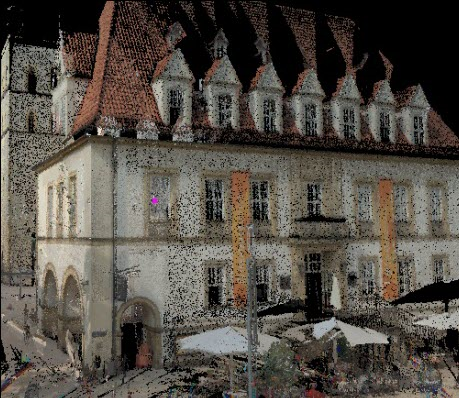
    <br>
    <figcaption>Figure 1. Visualization of point cloud dataset with RGB values [3]. The features apart from X, Y and Z values, such as intensity and number of returns are quite valuable for the task of classification, but at the same time they are sensor dependent and could become the main reasons for loss of generalization.</figcaption>
</figure>

### Point Cloud Segmentation

Point Cloud Segmentation is a task where each point in the point cloud is assigned a label, representing a real-world entity as described above. It is different from Point Cloud Categorization where the complete point cloud dataset is given one label.

<figure>
        <img src="https://miro.medium.com/max/1430/1*pmrkOrwErKZlcAVas-2CaQ.png", align="center">
    <br>
    <figcaption>Figure 2. Left Image shows a raw XYZ lidar points whereas right image shows the same data labelled with different types of classes and represented by different colors. [2]</figcaption>

</figure>

Similar to how its done with traditional convolutional neural networks, the Point Cloud Segmentation process involves training – where the neural network learns from an already classified (labeled) point cloud dataset, where each point has a unique class code (see Figure 2. right image). These class codes are used to represent feature/s that we want the neural network to recognize. Note that one should not use a ‘thinned-out’ representation of a point cloud dataset that preserves only class codes of interest but drops a majority of the undesired return points, as we would like the neural network to learn and be able to differentiate points of interest class code and those that are not. Likewise, additional attributes that are present in training datasets, for example, Intensity, RGB, number of returns etc... will improve the model’s accuracy but could inversely affect it if those parameters are not present in the datasets used for inferencing. As a result, its recommended to use either a labeled portion of the data we are planning to do prediction on, or, to use a more generalized training model built with the most common attributes (for example, a model built to differentiate only with XYZ values would be the most generic model to use).

When training a PointCNN model, the raw point cloud dataset is first converted into blocks of points containing a specific number of points. These blocks then get passed into the model for training along with their labels. A similar process is followed when using the model for predictions as well.

### X-Conv Operation

As described in the Introduction section, a core part of the PointCNN framework is the X-Conv operation which is analogous to the convolution operation in CNNs. This operator performs a series of operations on a processed form of point cloud blocks, such as sampling and normalization using K-Nearest Neighbors. 

Let's illustrate this step with an example. The first step involves sampling several points, lets call it sample P from the input set of points N. Then, for P number of points we find K nearest neighbors from N points. This process is performed to form a local neighborhood of points for each point in P. This local neighborhood of points is then brought to a local coordinate space for each neighborhood. After these operations we get an array of points of the shape (P, K, 3+E), where E is the number of extra features present (such as intensity, RGB values or the number of returns), other than XYZ.

<figure>
        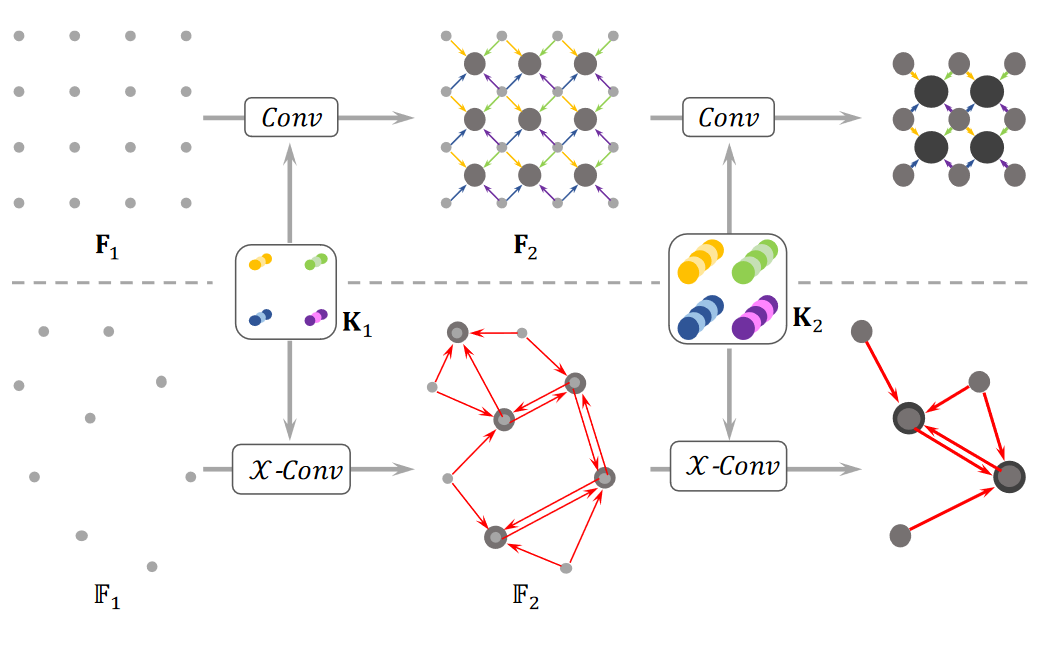
    <br>
    <figcaption>Figure 3. A diagram illustrating the difference and similarities of hierarchical convolution and Point CNN. The process above the dotted line denotes CNN in regular grids where convolutions are recursively applied on local grid patches. The process involves grid reductions – as done similarly in raster processing or meshing reducing the grid resolution successively (4X4⇥3X3⇥2X2), while increasing the channel number (visualized by dot thickness). Similarly, in point clouds, X-Conv is recursively applied to “project”, or “aggregate”, information from neighborhoods into fewer representative points (9⇥5⇥2) but each with richer information. [1]</figcaption>
</figure>

### PointCNN Segmentation Architecture

The PointCNN network for Point Cloud Segmentation has a similar architecture to U-Net, as described in the "How U-net works?" [4] guide. Here too, we use an encoder-decoder paradigm, where the encoder reduces the number of points while increasing the number of channels. Then, the decoder part of the network increases the number of points, and the number of channels is incrementally reduced. The network also uses ‘skip connections’ similar to how its done in the U-Net architecture. 

The difference is that the network processes a block of points as input and uses the X-Conv operation instead of Conv2D.

To state it succinctly, PointCNN differs from conventional grid based CNNs primarily due to the application of X-Conv layers; even then, the general process is similar to how CNNs are used in grid-based convolution frameworks. The main differences are with respect to:

1. the way the local regions are extracted (K ⇥K patches vs. K neighboring points around representative points)
2. the way the information from local regions is learned (Conv vs. X-Conv) [1]

<figure>
        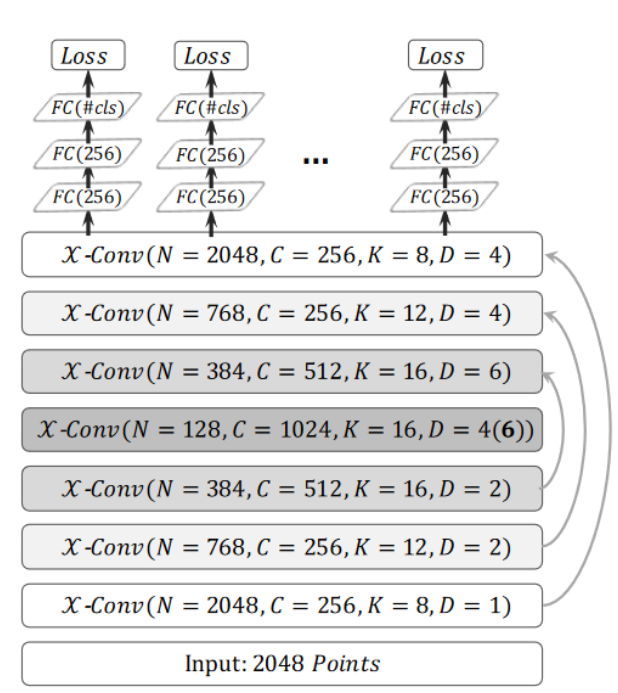
    <br>
    <figcaption>Figure 4. A Generalized representation of a PointCNN for Segmentation Architecture [1]. In each X-Conv operation N represents number of points in next layer, C represents number of channels, K represents the number of nearest neighbors and D represents dilation rate. [1]</figcaption>
</figure>

### Implementation in `arcgis.learn`

When training a PointCNN model using `arcgis.learn` , the raw point cloud dataset in LAS files is first converted into blocks of points containing a specific number of points and their labels.

```python
path = r'path\to\las_files' 
output_path = r'path\to\exported_data' 
export_point_dataset(path, output_path, 50.0, 8192, [('intensity', 5000, 0), ('num_returns', 5, 0)]
```

These blocks are used to create a `data bunch` object that is passed into the `PointCNN` model for training.

```python
colormap = {'0':[220,220,220], '1':[255,0,0], '2':[0,255,0], '3':[0,0,255]}
data = prepare_data(output_path, dataset_type='PointCloud', batch_size=2, color_mapping=colormap)
pointcnn = PointCNN(data)
```

#### For advanced users 

We can also specify all the additional parameters while initializing PointCNN in the form of using keyword arguments. The keyword argument takes in a parameter named `encoder_params` keyword argument, in which we can be used to specify the number of output channels for each layer in the encoder. The decoder of the network is built accordingly.

There are mainly four things that we need to define in the encoder, `out_channels`, `P`, `K`, `D`. All of These are described in the section above and which are supplied as a python lists. The `out_channel` specifies number of channels after each layer. `P`, `K` and `D` specifiy the number of points, k-nearest-neighbor and dilation rate in each layer. Additionally, one can specify `m` is the multiplicative factor, which is multiplied by each element of out_channel list. The other keyword arguments are `dropout` and `sample_point_num`. The dropout keyword argument specifies the amount of regularization we want to add in the model, its with values ranging between 0 and 1. The `sample_point_num` keyword argument specifies the number of points that we would like to train the model on. It is usually equal to the number of maximum points in a block during while exporting the point dataset.

A typical usage looks like:

```python
pointcnn = PointCNN(data=data, 
                    encoder_params={'out_channels':[16, 32, 64, 96],
                                    'P':[-1, 768, 384, 128],
                                    'K':[12, 16, 16, 16],
                                    'D':[1, 1, 2, 2],
                                    'm':8
                                    },  
                    dropout=0.5,
                    sample_point_num=8192
                   )
```


### Setup

Though the instructions below are for a typical Windows installation environment, the procedures  also apply (with minor modifications) to other operating systems. For Ubuntu, you may use the script [here](https://github.com/Esri/arcgis-python-api/tree/master/misc/tools/pointcnn_ubuntu.sh) to install the dependencies.

Before we can install and compile the PointCNN framework and get access to it in our geospatial deep learning environment, various required libraries and dependencies must be installed. Step by step instruction to install the required libraries and dependencies to get the PointCNN framework up and running in the arcgis.learn environment are described below:

 **1.** Install Visual C++14 from [this link](https://download.microsoft.com/download/5/f/7/5f7acaeb-8363-451f-9425-68a90f98b238/visualcppbuildtools_full.exe).
 
 
 **2.** Install CUDA Toolkit (10.1) from Nvidia website, or you can go to [this link](https://developer.nvidia.com/cuda-10.1-download-archive-update2). 


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;_Note: Instead of a complete 'CUDA Toolkit installation', you can do a custom installation and choose only 'CUDA Runtime' option as shown in Fig. 5._

<br>
<figure>
        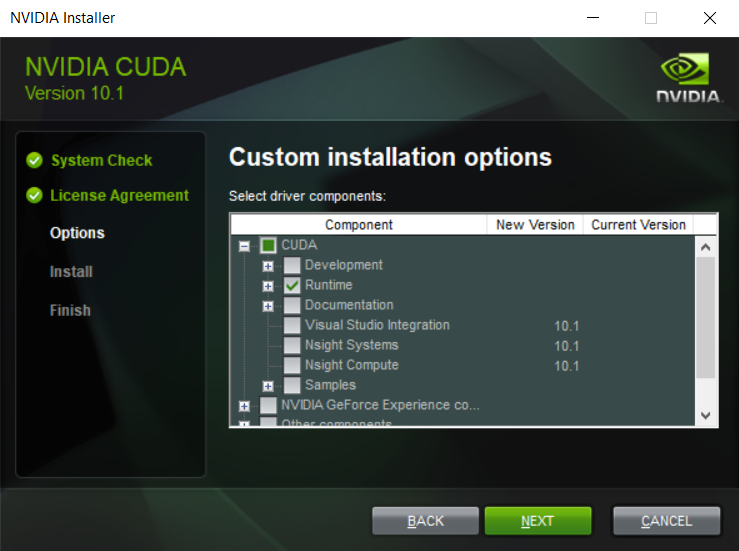
<center>
    <br>
    <figcaption>Figure 5. Cuda compiler installation.</figcaption>
</center>
</figure>

### For ArcGIS Pro users:
<p> </p>
<h4>Open 'Python command prompt'. And execute the following commands.</h4>

`conda create -n arcgis.learn.pro.env --clone arcgispro-py3`

`conda activate arcgis.learn.pro.env`

`conda install -c esri arcgis`

`conda install -c esri -c fastai -c pytorch scikit-image=0.15.0 pillow=6.2.2 libtiff=4.0.10 fastai=1.0.60 pytorch=1.4.0 torchvision=0.5.0 cudatoolkit=10.1.243`


`conda install -c plotly plotly=4.5.0 plotly-orca=1.2.1 psutil=5.7.0`

`pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 torch-cluster==latest+cu101 torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html`


`pip install torch-geometric==1.5.0 transforms3d==0.3.1 laspy==1.7.0`


_Note: "arcgis.learn.pro.env" is not exclusive to PointCNN, but can be used for other models too, while, the 'TF support' dependencies are not present in "arcgis.learn.pro.env"._


### For Anaconda users:
<p> </p>
<h4>Open 'Anaconda command prompt'. And execute the following commands.</h4>


_(Install Anaconda from [here](https://repo.anaconda.com/archive/Anaconda3-2020.02-Windows-x86_64.exe).)_

`conda create -n arcgis.learn.ana.env `

`conda activate arcgis.learn.ana.env`

`conda install -c esri arcgis`

`conda install -c esri -c fastai -c pytorch scikit-image=0.15.0 pillow=6.2.2 libtiff=4.0.10 fastai=1.0.60 pytorch=1.4.0 torchvision=0.5.0 cudatoolkit=10.1.243`


`conda install -c plotly plotly=4.5.0 plotly-orca=1.2.1 psutil=5.7.0`


`pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 torch-cluster==latest+cu101 torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html`


`pip install torch-geometric==1.5.0 transforms3d==0.3.1 laspy==1.7.0 h5py==2.10.0`


`conda install -c anaconda gdal=2.3.3`


_Note: "arcgis.learn.ana.env" is not exclusive to PointCNN, but can be used for other models too, while, the 'TF support' dependencies are not present in "arcgis.learn.ana.env"._


### References

* [1] Yangyan Li, Rui Bu, Mingchao Sun, Wei Wu, Xinhan Di: “PointCNN: Convolution On $\mathcal{X}$-Transformed Points"

* [2] Dmitry Kudinov: "PointCNN: replacing 50,000 man hours with AI"

* [3] Autodesk Help: "About Point Cloud Color Stylization and Visual Effects" https://knowledge.autodesk.com/support/autocad/learn-explore/caas/CloudHelp/cloudhelp/2020/ENU/AutoCAD-Core/files/GUID-75EBFA48-CB7E-4E91-A1BB-167D96A7119F-htm.html

* [4] Esri: "How U-net works?" https://developers.arcgis.com/python/guide/how-unet-works/